In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model
from circuits.pqc_circuits import qiskit_PQC_RZRX, qiskit_PQC_RXRZ, qiskit_PQC_RXRZRY

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data

from models.qiskit_models import SimpleQiskitQuantumModel


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
INPUT_BITS = '10101'
EPOCHS = 6
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()

# ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)

pqc_arch = qiskit_PQC_RZRX

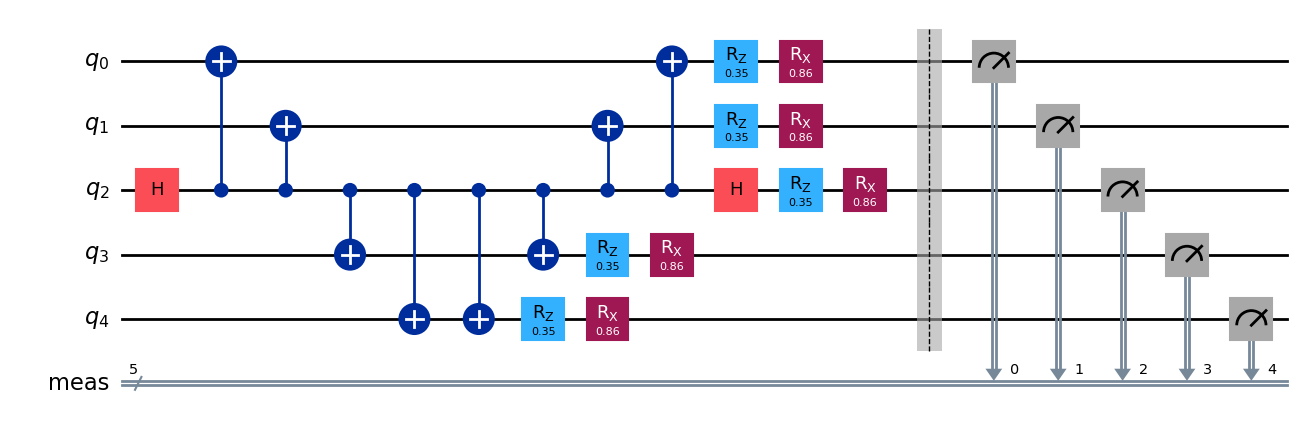

In [6]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(2)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params, pqc_arch)
test_circ_pqc.draw('mpl')

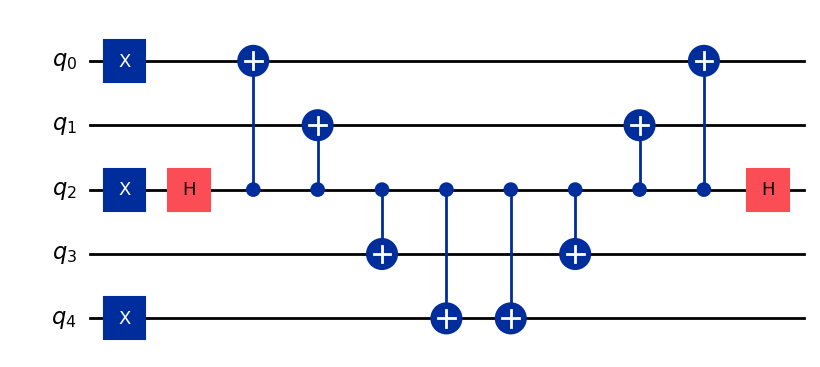

In [7]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(5,2))
mcirc.draw('mpl')

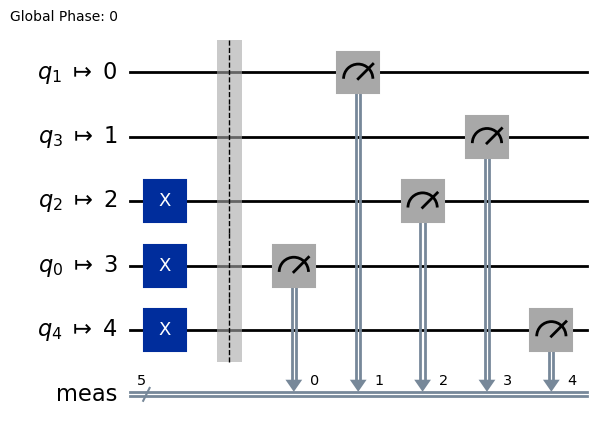

In [8]:
mcirc_measured = mcirc.measure_all(inplace=False)
transpiled_circ = transpile(mcirc_measured, noisy_sim)
transpiled_circ.draw('mpl')

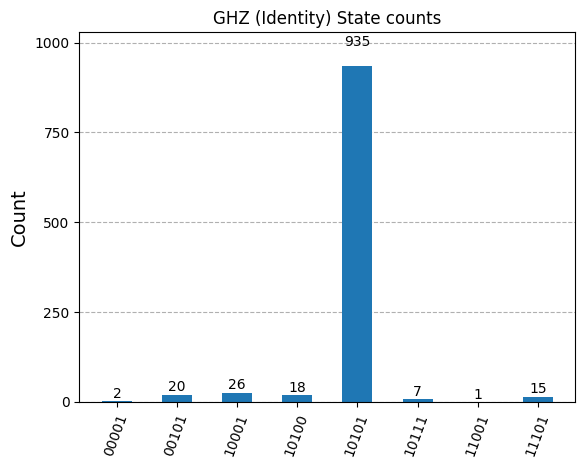

In [9]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='GHZ (Identity) State counts')

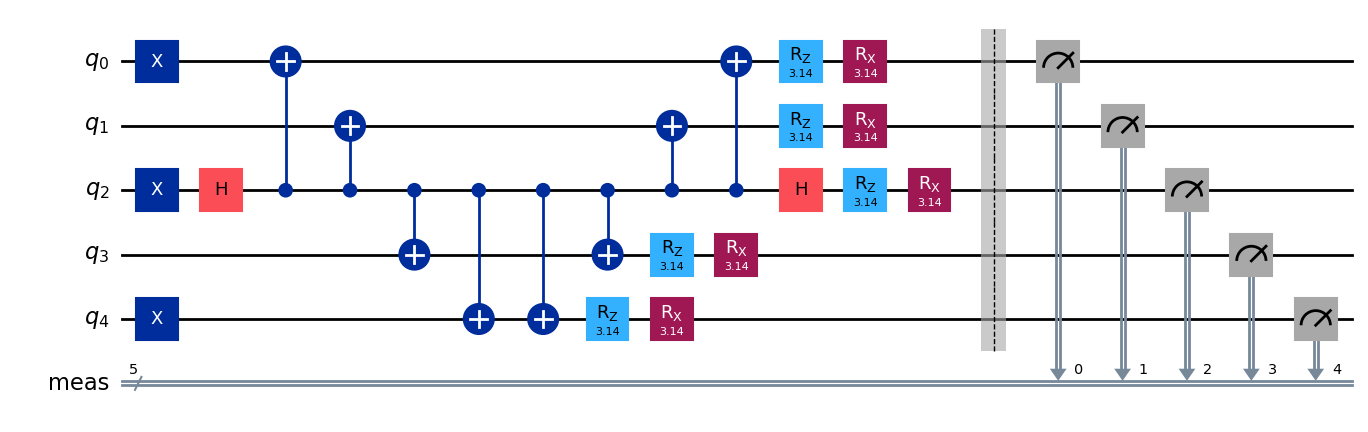

In [10]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.full((2,), torch.pi), pqc_arch)
mcirc_pqc.draw('mpl')

# Autorgrad Function, followed by Model

In [11]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=10000, get_soft=False)
print(len(ideal_data[10][1]))

32


In [12]:
ghz_circuit = custom_ghz(NUM_QUBITS, 2)
pqc_model = SimpleQiskitQuantumModel(num_params=2, simulator=noisy_sim, 
                                     num_shots=NUM_SHOTS, base_circuit=ghz_circuit,
                                     pqc_arch_func=pqc_arch)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


# loss_fn = nn.MSELoss()
loss_fn = nn.KLDivLoss(reduction='batchmean')

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(device)

mps


In [13]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = []
    shuffle(ideal_data)
    for bitstring, ideal in ideal_data:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=get_circuit_for_model(bitstring, ghz_circuit))
        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        # print(param_list)


        if (ctr) % (len(ideal_data) // 10) == 0:
            
            print(f'Count {ctr}, Loss: {loss:.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1
Count 1000, Loss: -107.9812, Params: Parameter containing:
tensor([1.6406, 1.8166], requires_grad=True)
Count 2000, Loss: -495.5521, Params: Parameter containing:
tensor([1.4844, 1.6437], requires_grad=True)
Count 3000, Loss: -1040.3844, Params: Parameter containing:
tensor([1.3432, 1.4872], requires_grad=True)
Count 4000, Loss: -1357.2699, Params: Parameter containing:
tensor([1.2153, 1.3457], requires_grad=True)
Count 5000, Loss: -4167.3735, Params: Parameter containing:
tensor([1.0996, 1.2176], requires_grad=True)
Count 6000, Loss: 0.6577, Params: Parameter containing:
tensor([0.9950, 1.1017], requires_grad=True)
Count 7000, Loss: -8472.1562, Params: Parameter containing:
tensor([0.9003, 0.9968], requires_grad=True)
Count 8000, Loss: -403.5446, Params: Parameter containing:
tensor([0.8146, 0.9020], requires_grad=True)
Count 9000, Loss: -491.6438, Params: Parameter containing:
tensor([0.7370, 0.8161], requires_grad=True)
Count 10000, Loss: 154.9160, Params: Parameter

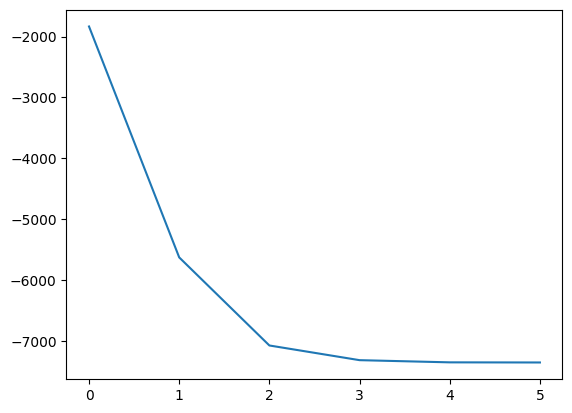

In [14]:
plt.plot([i for i in range(len(loss_list_epoch))], loss_list_epoch)
plt.show()

In [15]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[1.812999   1.8128177  1.8126364  ... 0.00448953 0.00448908 0.00448863]
 [2.0074887  2.007288   2.0070872  ... 0.00497111 0.00497061 0.00497011]]


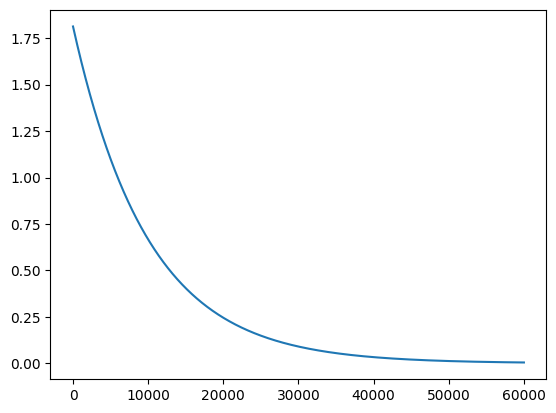

In [16]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[0])
plt.show()

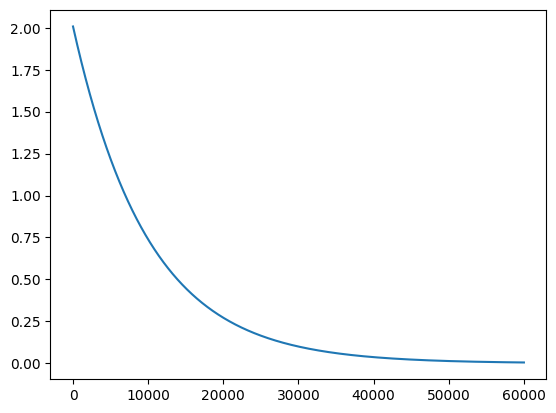

In [17]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[1])
plt.show()

In [18]:
pqc_model.pqc_params

Parameter containing:
tensor([0.0045, 0.0050], requires_grad=True)

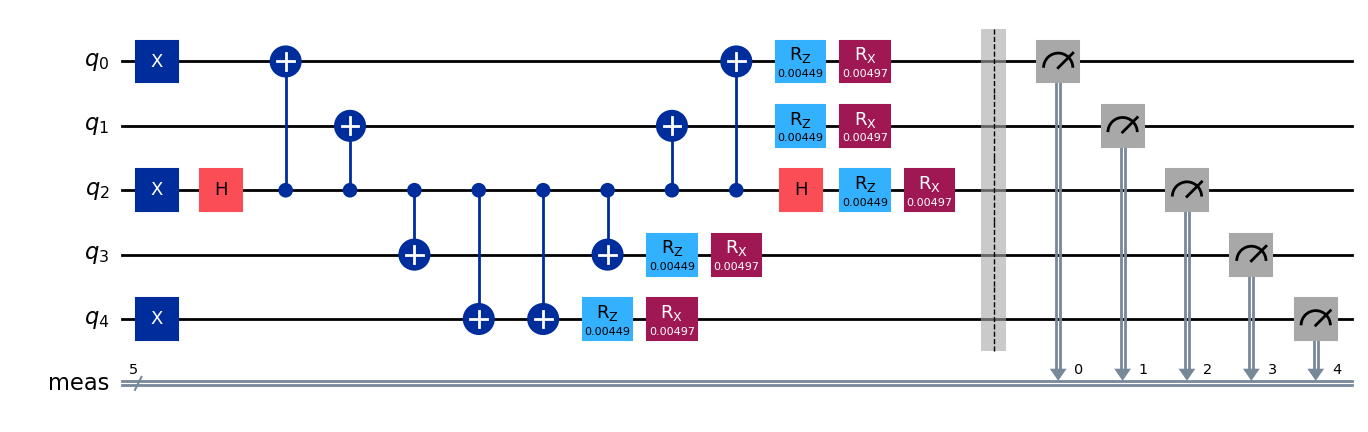

In [19]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

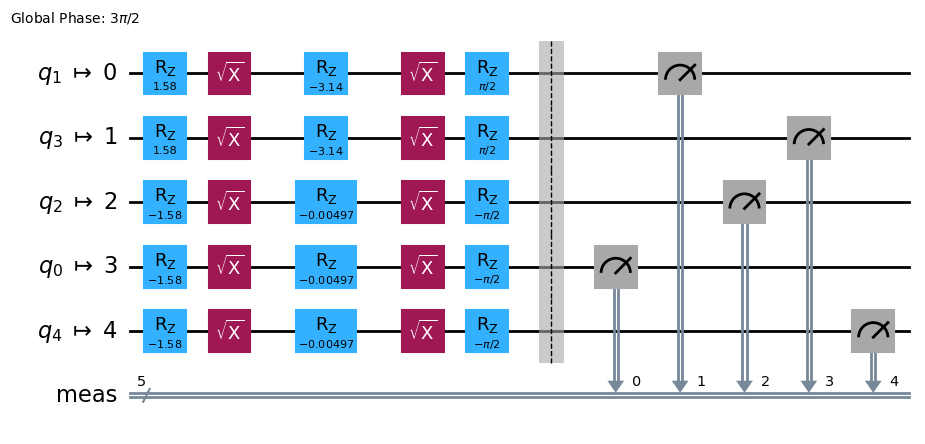

In [20]:

transpiled_circ = transpile(mcirc_post, noisy_sim)
transpiled_circ.draw('mpl')

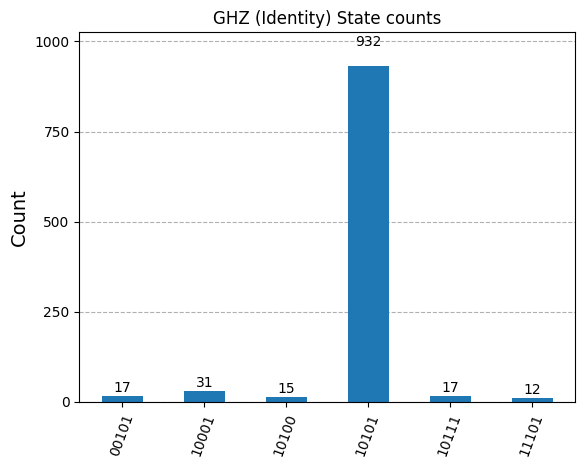

In [21]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

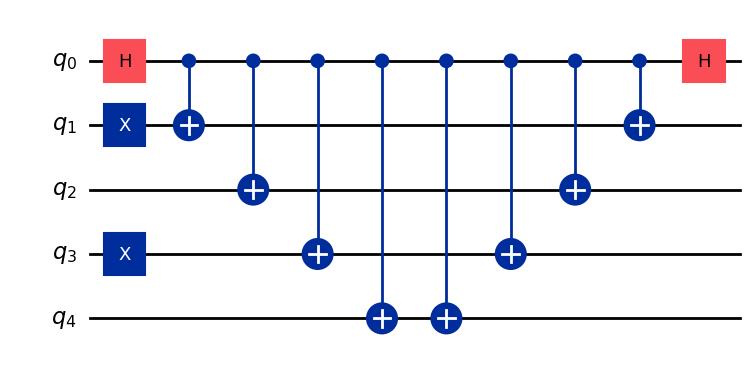

In [22]:
mcirc = get_circuit_for_model('01010', custom_ghz(5,0))
mcirc.draw('mpl')

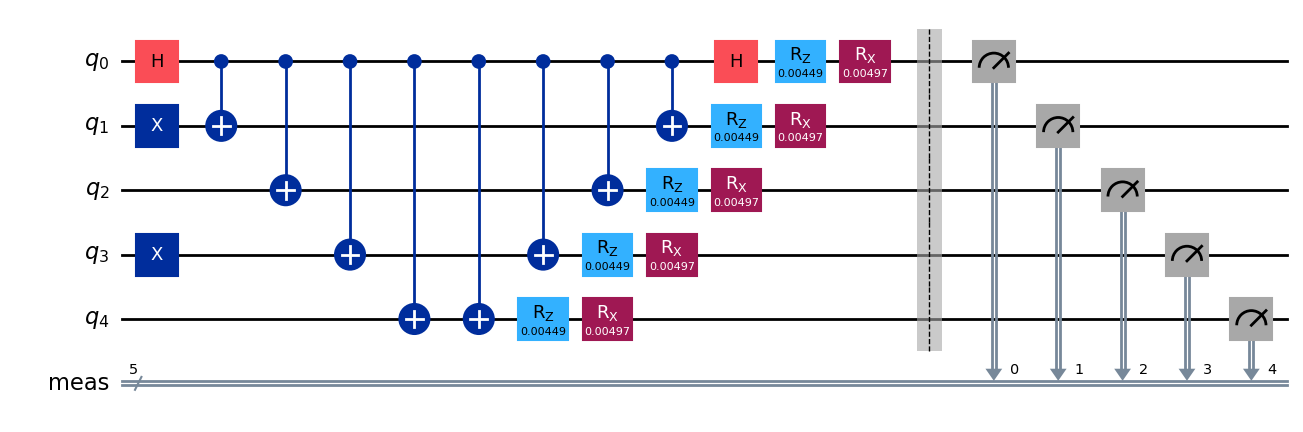

In [23]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

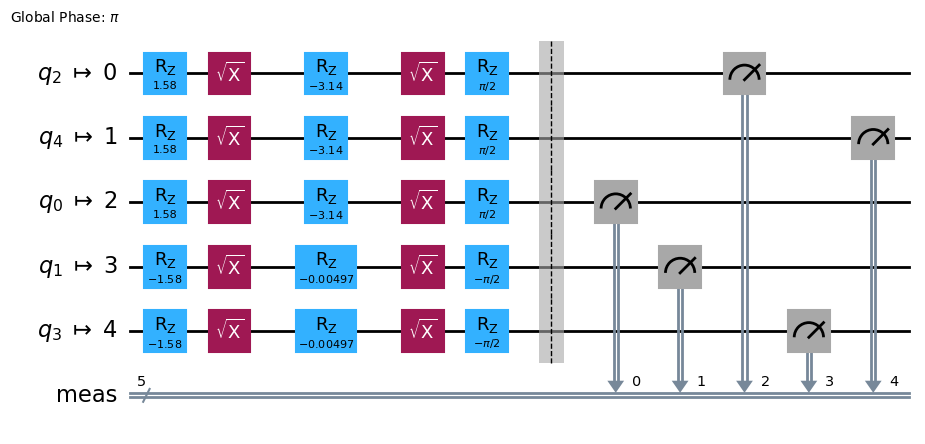

In [24]:
transpiled_circ = transpile(mcirc_post, noisy_sim)
transpiled_circ.draw('mpl')

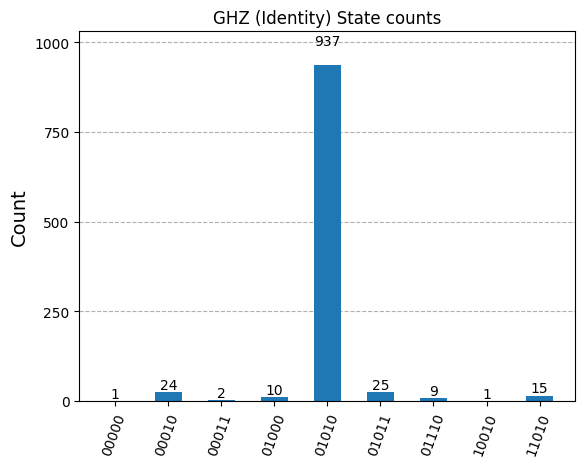

In [25]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')